In [ ]:
#step 1: Dataset with images and videos


In [1]:
#✅ Step 2: Explore Dataset Structure & Extract Video Paths
import os
import pandas as pd

# 👇 Update this path to match your folder structure
dataset_path = r'C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos'

video_data = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            pose_name = os.path.basename(root)
            file_type = 'correct' if 'correct' in file.lower() else 'incorrect'
            angle_info = ''
            if 'angle' in file.lower():
                angle_info = [part for part in file.lower().split('_') if 'angle' in part]
                angle_info = angle_info[0] if angle_info else ''
            
            video_path = os.path.join(root, file)
            video_data.append({
                'Pose': pose_name,
                'Type': file_type,
                'Angle': angle_info,
                'VideoPath': video_path
            })

# Display the result
df_videos = pd.DataFrame(video_data)
df_videos.head(10)


,Pose,Type,Angle,VideoPath
0,Right Steps,incorrect,anantasana right step angle 1-converted.mp4,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
1,Right Steps,incorrect,anantasana right step angle 2-converted.mp4,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
2,Right Steps,incorrect,anantasana right step angle 3-converted.mp4,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
3,Right Steps,incorrect,anantasana right step angle 4-converted.mp4,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
4,Wrong Steps,incorrect,anantasana wrong step angle 1-converted.mp4,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
5,Wrong Steps,incorrect,anantasana wrong step angle 2-converted.mp4,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
6,Wrong Steps,incorrect,anantasana wrong step angle 3-converted.mp4,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
7,Wrong Steps,incorrect,anantasana wrong step angle 4-converted.mp4,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
8,Right Steps,incorrect,ardhakati chakrasana right step angle 1-conver...,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...
9,Right Steps,incorrect,ardhakati chakrasana right step angle 2-conver...,C:\Users\Swetha Dhanasekar\Yoga Postures Datas...


In [2]:
#Step 3: Extract Frames from the Videos
#📌 First, Setup Output Folder:
import os
import cv2

input_video_base = r'C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos'  # Your root video folder
output_base = './output_frames_26April'
os.makedirs(output_base, exist_ok=True)

def extract_frames(video_path, output_dir, interval=30):
    cap = cv2.VideoCapture(video_path)
    count = 0
    frame_id = 0
    if not cap.isOpened():
        print(f"⚠️ Failed to open: {video_path}")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if count % interval == 0:
            frame_path = os.path.join(output_dir, f"frame_{frame_id:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_id += 1
        count += 1
    cap.release()

# ✅ Walk through folders
for pose in os.listdir(input_video_base):
    pose_path = os.path.join(input_video_base, pose)
    if not os.path.isdir(pose_path):
        continue
    for label in os.listdir(pose_path):
        label_path = os.path.join(pose_path, label)
        if not os.path.isdir(label_path):
            continue
        for video_file in os.listdir(label_path):
            if video_file.endswith(".mp4"):
                video_path = os.path.join(label_path, video_file)
                output_dir = os.path.join(output_base, pose, label)
                os.makedirs(output_dir, exist_ok=True)
                print(f"🎥 Extracting: {video_path}")
                extract_frames(video_path, output_dir)


🎥 Extracting: C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos\Anantasana\Right Steps\Anantasana Right Step Angle 1-converted.mp4
🎥 Extracting: C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos\Anantasana\Right Steps\Anantasana Right Step Angle 2-converted.mp4
🎥 Extracting: C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos\Anantasana\Right Steps\Anantasana Right Step Angle 3-converted.mp4
🎥 Extracting: C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos\Anantasana\Right Steps\Anantasana Right Step Angle 4-converted.mp4
🎥 Extracting: C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos\Anantasana\Wrong Steps\Anantasana Wrong Step Angle 1-converted.mp4
🎥 Extracting: C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos\Anantasana\Wrong Steps\Anantasana Wrong Step Angle 2-converted.mp4
🎥 Extracting: C:\Users\Swetha Dhanasekar\Yoga Postures Dataset\Videos\Anantasana\Wrong Steps\Anantasana Wrong Step Angle 3-converted.mp4
🎥 Extracting: C:\Users\Swetha Dhanasekar\

In [4]:
#Step 4: Extract Pose Landmarks from Frames (MediaPipe)
#Import MediaPipe
import os
import mediapipe as mp
import numpy as np

#Initialize Pose Estimator
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1)

#Define Function to Extract Landmarks from a Frame
def extract_pose_keypoints(image_path):
    import cv2
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(image_rgb)
    
    if result.pose_landmarks:
        keypoints = []
        for lm in result.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
        return keypoints
    else:
        return None  # Pose not detected

#Loop Through All Frames and Save to CSV
import glob
import csv

# Prepare CSV file
output_csv = 'pose_keypoints_26April.csv'
header = ['pose', 'type', 'image_path']
for i in range(33):  # 33 keypoints
    header += [f'x{i}', f'y{i}', f'z{i}', f'v{i}']

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)

    # Loop through all pose folders
    for pose_name in os.listdir('./output_frames_26April'):
        for pose_type in ['Right Steps', 'Wrong Steps']:
            frame_folder = f'./output_frames_26April/{pose_name}/{pose_type}'
            if not os.path.exists(frame_folder):
                continue
            frame_paths = glob.glob(os.path.join(frame_folder, '*.jpg'))

            for path in frame_paths:
                keypoints = extract_pose_keypoints(path)
                if keypoints:
                    row = [pose_name, pose_type, path] + keypoints
                    writer.writerow(row)


Classification Report:

                      precision    recall  f1-score   support

          Anantasana       0.97      0.97      0.97        38
Ardhakati Chakrasana       0.97      1.00      0.98        32
        Bhujangasana       1.00      1.00      1.00        30
     Kati Chakrasana       1.00      1.00      1.00        32
        Marjariasana       1.00      1.00      1.00        29
         Parvatasana       0.86      1.00      0.92        24
        Sarvangasana       1.00      0.83      0.91        24
            Tadasana       1.00      0.97      0.98        30
           Vajrasana       1.00      1.00      1.00        23
     Viparita Karani       1.00      1.00      1.00        28

            accuracy                           0.98       290
           macro avg       0.98      0.98      0.98       290
        weighted avg       0.98      0.98      0.98       290

Confusion Matrix:

[[37  0  0  0  0  1  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0 

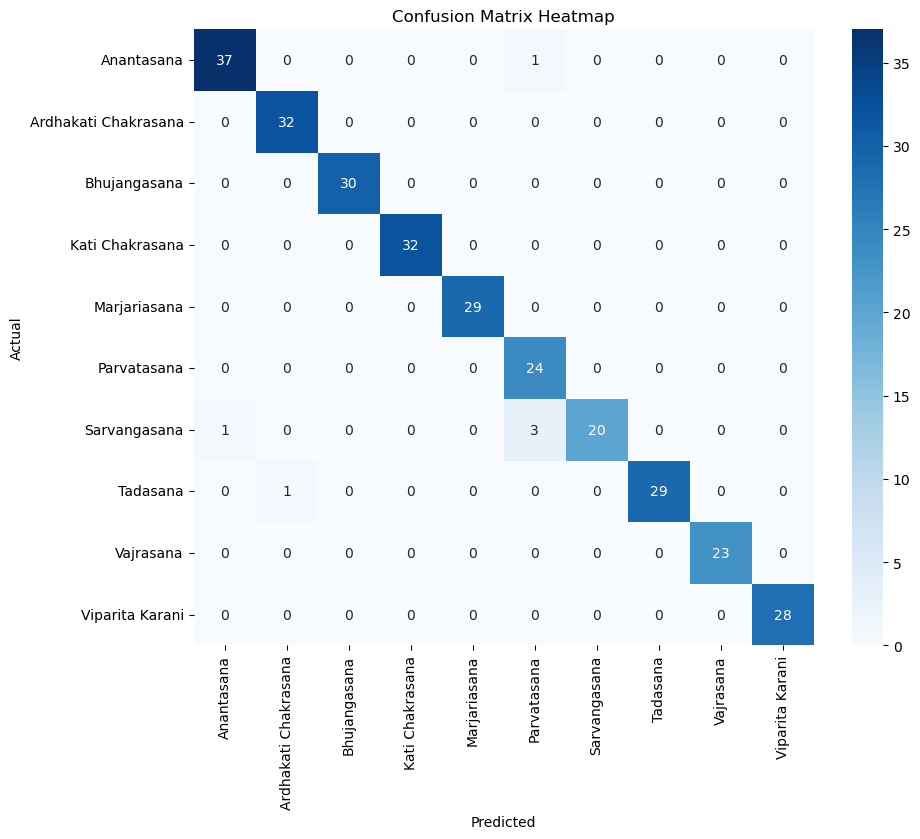

In [6]:
#Step 5: Train a Machine Learning Model to Classify Yoga Poses

#Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Load Your CSV
df = pd.read_csv('pose_keypoints_26April.csv')
df.dropna(inplace=True)  # Drop rows with missing values (if any)
df.head() # Preview

#Prepare Features and Labels
#Option A: Classify Pose Name (Tadasana, Bhujangasana, etc)
X = df.iloc[:, 3:].values  # keypoints (x0 to v32)
y = df['pose']  # label = pose name

#Option B: Classify Pose Type (correct/incorrect)
# If you prefer binary classification (correct vs incorrect):
# y = df['type']

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#Evaluate the Model
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# Accuracy
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

#Plotting Heatmap
# Predict again if needed
y_pred = clf.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = clf.classes_

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [4]:
!pip install tensorflow

C:\Users\Swetha Dhanasekar\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1957 - loss: 2.2189 - val_accuracy: 0.3931 - val_loss: 1.8420
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4183 - loss: 1.7613 - val_accuracy: 0.5655 - val_loss: 1.5275
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5160 - loss: 1.5040 - val_accuracy: 0.6517 - val_loss: 1.2791
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6176 - loss: 1.2532 - val_accuracy: 0.7000 - val_loss: 1.1446
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6596 - loss: 1.1529 - val_accuracy: 0.6931 - val_loss: 1.0295
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6410 - loss: 1.0573 - val_accuracy: 0.7276 - val_loss: 0.9325
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6978 - loss: 0.8984 - val_accuracy: 0.7621 - val_loss: 0.8311
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7250 - loss: 0.8740 - val_accuracy: 0.7862 - val_lo

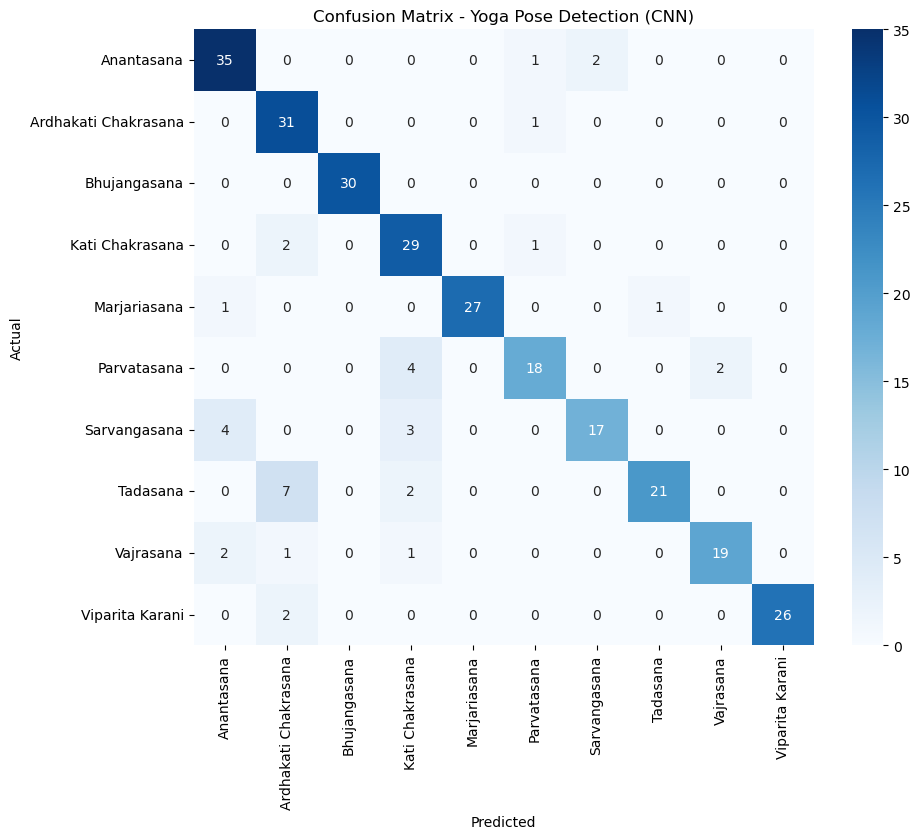

In [2]:
# 📌 Full Clean Version: CNN for Yoga Pose Detection from Pose Keypoints

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load CSV Data
df = pd.read_csv('pose_keypoints_26April.csv')
df.dropna(inplace=True)

# Step 3: Prepare Features and Labels
# Select only 99 landmark features (x, y, z for 33 keypoints)
X = df.iloc[:, 3:102].values  # Correct slicing

# Labels
y = df['pose']

# Encode Labels
le = LabelEncoder()
y = le.fit_transform(y)

# Step 4: Reshape X
X = X.reshape(X.shape[0], 33, 3)  # Reshape to (samples, 33 keypoints, 3 coordinates)

# Step 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 6: Build CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(33, 3)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

# Step 7: Compile Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 8: Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16
)

# Step 9: Evaluate Model
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Step 10: Print Reports
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Yoga Pose Detection (CNN)")
plt.show()


In [7]:
#save the model
import joblib
joblib.dump(clf, 'pose_classifier_26April.pkl')


['pose_classifier_26April.pkl']

In [1]:
#Step 6: Pose Prediction + Trigger Audio Alerts - (both for Upload Images and Webcam Real-Time)
# Step 6: Real-time Pose Prediction and Audio Trigger
import cv2
import mediapipe as mp
import numpy as np
import joblib
from gtts import gTTS
import os

# Load your trained model
clf = joblib.load('pose_classifier_26April.pkl')

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1)
mp_drawing = mp.solutions.drawing_utils

# Function to extract keypoints
def extract_keypoints(image):
    result = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if result.pose_landmarks:
        keypoints = []
        for lm in result.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
        return np.array(keypoints).reshape(1, -1), result
    else:
        return None, None

# Function to trigger audio
def play_audio(message, filename="temp_alert.mp3"):
    tts = gTTS(text=message, lang='en')
    tts.save(filename)
    os.system(f"start {filename}")  # Windows
    # os.system(f"afplay {filename}")  # Mac

# Load your test image
#test_image_path = r'C:\Users\Swetha Dhanasekar\output_frames_26April\Anantasana\Right Steps\frame_0036.jpg'  # <-- Correct pose
#test_image_path = r'C:\Users\Swetha Dhanasekar\output_frames_26April\Bhujangasana\Right Steps\frame_0038.jpg'
#test_image_path = r"C:\Users\Swetha Dhanasekar\output_frames_26April\Marjariasana\Right Steps\frame_0037.jpg"

test_image_path = r'C:\Users\Swetha Dhanasekar\output_frames_26April\Anantasana\Wrong Steps\frame_0000.jpg'  # <-- incorrect pose
image = cv2.imread(test_image_path)

if image is None:
    print(f"Image not found: {test_image_path}")
    exit()

# Predict
keypoints, result = extract_keypoints(image)

if keypoints is not None:
    prediction = clf.predict(keypoints)[0]
    print(f"Predicted Pose: {prediction}")

    if "Wrong Steps" in prediction.lower():
        print("⚠️ Incorrect Pose! Please Adjust.")
        play_audio("Incorrect pose detected. Please adjust your posture.")
    else:
        print("✅ Correct Pose!")
        play_audio("Good job! Correct pose detected.")

    # Draw landmarks
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(annotated_image, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2.putText(annotated_image, prediction, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show the result
    cv2.imshow('Pose Prediction', annotated_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

else:
    print("⚠️ Pose not detected in image.")
    play_audio("Pose not detected. Please try again.")


Predicted Pose: Anantasana
✅ Correct Pose!
